In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
import os

In [2]:
import os
import io
import json
import textwrap
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import joblib

In [3]:
# ---------- 0) Constants & paths ----------
BASE_DIR = Path(r"D:\ProjectData")
BASE_DIR2 = Path(r"D:\ProjectOutputs")
BASE_DIR.mkdir(parents=True, exist_ok=True)

RAW_CSV_PATH = BASE_DIR / "amazon_eco-friendly_products.csv"
CLEAN_CSV_PATH = BASE_DIR2 / "eco_products_clean.csv"
TFIDF_PATH = BASE_DIR2 / "tfidf_vectorizer.joblib"
SIM_MATRIX_PATH = BASE_DIR2 / "cosine_similarity.npy"
MODEL_SCRIPT_PATH = BASE_DIR2 / "ecoreco_recommender.py"
README_PATH = BASE_DIR2 / "README_EcoReco.md"


df = pd.read_csv(RAW_CSV_PATH)
df.head()

,id,title,name,category,material,brand,price,rating,reviewsCount,description,url,img_url,inStock,inStockText
0,B0CWH366KJ,"Agfabric Natural Jute Erosion Control, 16yard(...",Weed Barrier Fabric,"Patio, Lawn & Garden",NaN,Agfabric,$87.3,NaN,NaN,Protect your yard and garden with our biodegra...,https://www.amazon.com/dp/B0CWH366KJ,https://m.media-amazon.com/images/I/71t3FD5KjH...,True,Only 5 left in stock - order soon.
1,B086L692VC,SAFAVIEH Braided Collection 4' Round Light Blu...,Area Rugs,Home & Kitchen,"50%jute, 25% Wool, 25% Cotton",Safavieh,$40.63,4.2,59.0,Country style is perfect for a casual cottage ...,https://www.amazon.com/dp/B086L692VC,https://m.media-amazon.com/images/I/A1Q73Cheh2...,True,Only 3 left in stock - order soon.
2,B01J6JELTG,Eyeseals 4.0 Sleep Mask – Clear – Moisturizing...,Sleeping Masks,Health & Household,Plastic,EYEECO,$65.95,3.7,1075.0,Locks moisture in: Eyeseals 4.0 eye mask for d...,https://www.amazon.com/dp/B01J6JELTG,https://m.media-amazon.com/images/I/61Uz393xlp...,True,NaN
3,B07HQSKK36,Lucky Monet 25/50/100PCS Burlap Gift Bags Wedd...,Gift Bags,Health & Household,Burlap,Lucky Monet,$29.99,4.6,2492.0,❤ Premium Burlap Material❤ These small burlap ...,https://www.amazon.com/dp/B07HQSKK36,https://m.media-amazon.com/images/I/71DrHIU1aM...,True,In Stock In Stock
4,B0C3Y8WJDR,St. Boniface Bag Company | Burlap Bags - Size:...,Grow Bags,"Patio, Lawn & Garden",5.0 Count,Generic,$29.99,4.4,11.0,100% Burlap > 100% BIODEGRADABLE AND ECO FRIEN...,https://www.amazon.com/dp/B0C3Y8WJDR,https://m.media-amazon.com/images/I/81q3el899U...,True,In Stock


In [4]:
# ---------- 2) Load & clean data ----------
def parse_price(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().replace(",", "")
    s = s.replace("$", "")  # USD-style currency
    try:
        return float(s)
    except ValueError:
        return np.nan

def to_bool(x):
    if isinstance(x, str):
        return x.strip().lower() in ("true", "1", "yes", "y")
    return bool(x) if pd.notna(x) else False

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Clean numeric fields
df["price_num"] = df["price"].apply(parse_price)
df["rating_num"] = pd.to_numeric(df["rating"], errors="coerce")
df["reviews_num"] = pd.to_numeric(df["reviewsCount"], errors="coerce")

# Basic text cleaning & combine fields
for col in ["title", "material", "description", "brand", "category", "name"]:
    if col not in df.columns:
        df[col] = ""
    df[col] = df[col].fillna("").astype(str).str.replace("\s+", " ", regex=True).str.strip()

df["combined_text"] = (
    df["title"] + " " +
    df["material"] + " " +
    df["description"]
).str.lower()

# Convenience fields
df["in_stock_bool"] = df["inStock"].apply(to_bool)

# Save cleaned CSV
df.to_csv(CLEAN_CSV_PATH, index=False)


# ---------- 3) TF-IDF + cosine similarity ----------
# Use unigrams + bigrams for richer matching in short titles
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1, 2), min_df=1)
tfidf_matrix = tfidf.fit_transform(df["combined_text"])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Persist artifacts
joblib.dump(tfidf, TFIDF_PATH)
np.save(SIM_MATRIX_PATH, cosine_sim)

In [5]:
# ---------- 4) Sustainability-aware reranking ----------
# Simple greenness proxy based on keywords (customize this list for your full dataset)
GREEN_KEYWORDS = [
    "jute", "burlap", "cotton", "recycled", "biodegradable", "compostable",
    "hemp", "bamboo", "organic", "eco", "sustainable", "low plastic", "plastic-free"
]

def green_score(text: str) -> float:
    txt = (text or "").lower()
    score = 0.0
    for kw in GREEN_KEYWORDS:
        if kw in txt:
            score += 1.0
    return score

df["green_score"] = df["combined_text"].apply(green_score)

# Normalize factors used in hybrid scoring
scaler = MinMaxScaler()
norm_cols = {}
for col in ["rating_num", "price_num", "reviews_num", "green_score"]:
    col_vals = df[[col]].fillna(0.0)
    norm_cols[col] = scaler.fit_transform(col_vals).ravel()

df["rating_norm"] = norm_cols["rating_num"]
df["price_norm"] = norm_cols["price_num"]
df["reviews_norm"] = norm_cols["reviews_num"]
df["green_norm"] = norm_cols["green_score"]

In [6]:
df.head()

,id,title,name,category,material,brand,price,rating,reviewsCount,description,...,price_num,rating_num,reviews_num,combined_text,in_stock_bool,green_score,rating_norm,price_norm,reviews_norm,green_norm
0,B0CWH366KJ,"Agfabric Natural Jute Erosion Control, 16yard(...",Weed Barrier Fabric,"Patio, Lawn & Garden",,Agfabric,$87.3,NaN,NaN,Protect your yard and garden with our biodegra...,...,87.30,NaN,NaN,"agfabric natural jute erosion control, 16yard(...",True,3.0,0.00,0.182705,0.000000,0.375
1,B086L692VC,SAFAVIEH Braided Collection 4' Round Light Blu...,Area Rugs,Home & Kitchen,"50%jute, 25% Wool, 25% Cotton",Safavieh,$40.63,4.2,59.0,Country style is perfect for a casual cottage ...,...,40.63,4.2,59.0,safavieh braided collection 4' round light blu...,True,2.0,0.84,0.085032,0.000221,0.250
2,B01J6JELTG,Eyeseals 4.0 Sleep Mask – Clear – Moisturizing...,Sleeping Masks,Health & Household,Plastic,EYEECO,$65.95,3.7,1075.0,Locks moisture in: Eyeseals 4.0 eye mask for d...,...,65.95,3.7,1075.0,eyeseals 4.0 sleep mask – clear – moisturizing...,True,1.0,0.74,0.138023,0.004026,0.125
3,B07HQSKK36,Lucky Monet 25/50/100PCS Burlap Gift Bags Wedd...,Gift Bags,Health & Household,Burlap,Lucky Monet,$29.99,4.6,2492.0,❤ Premium Burlap Material❤ These small burlap ...,...,29.99,4.6,2492.0,lucky monet 25/50/100pcs burlap gift bags wedd...,True,2.0,0.92,0.062764,0.009332,0.250
4,B0C3Y8WJDR,St. Boniface Bag Company | Burlap Bags - Size:...,Grow Bags,"Patio, Lawn & Garden",5.0 Count,Generic,$29.99,4.4,11.0,100% Burlap > 100% BIODEGRADABLE AND ECO FRIEN...,...,29.99,4.4,11.0,st. boniface bag company | burlap bags - size:...,True,4.0,0.88,0.062764,0.000041,0.500


In [7]:
def recommend(
    query: str,
    top_k: int = 5,
    alpha_sim: float = 0.65,     # similarity weight
    beta_green: float = 0.20,    # green score (+)
    gamma_rating: float = 0.10,  # rating weight (+)
    delta_price: float = 0.05,   # price penalty weight (−)
    filter_category: str = None,
    filter_brand: str = None,
    max_price: float = None
) -> pd.DataFrame:
    """
    Content-based recommendations with sustainability-aware reranking.
    Scoring = alpha*similarity + beta*green_norm + gamma*rating_norm - delta*price_norm
    """
    # Find query index by title containment (robust for partial matches)
    candidates = df.index[df["title"].str.contains(query, case=False, na=False)].tolist()
    if not candidates:
        # If not found by title, attempt a fallback using text similarity to the query itself
        q_vec = tfidf.transform([query.lower()])
        sim_to_query = cosine_similarity(q_vec, tfidf_matrix).ravel()
        idx = int(np.argmax(sim_to_query))
    else:
        idx = candidates[0]

    sim_scores = cosine_sim[idx].copy()

    #  Optional filtering
    mask = np.ones(len(df), dtype=bool)
    if filter_category:
        mask &= df["category"].str.contains(filter_category, case=False, na=False).values
    if filter_brand:
        mask &= df["brand"].str.contains(filter_brand, case=False, na=False).values
    if max_price is not None:
        price_ok = df["price_num"].fillna(np.inf).values <= float(max_price)
        mask &= price_ok

    # Exclude the query item from ranking
    mask[idx] = False

    # Score components
    sim_norm = (sim_scores - sim_scores.min()) / (sim_scores.max() - sim_scores.min() + 1e-9)

    score = (
        alpha_sim * sim_norm +
        beta_green * df["green_norm"].values +
        gamma_rating * df["rating_norm"].values -
        delta_price * df["price_norm"].values
    )

    # 4) Rank
    ranked_idx = np.argsort(-score)  # descending
    ranked_idx = [i for i in ranked_idx if mask[i]]

    top_idx = ranked_idx[:top_k]

    cols = ["id", "title", "brand", "category", "price", "rating", "reviewsCount", "url", "img_url"]
    out = df.iloc[top_idx].copy()
    out["eco_score"] = df.iloc[top_idx]["green_norm"].round(3)
    out["similarity"] = sim_norm[top_idx].round(3)
    out["hybrid_score"] = score[top_idx].round(3)
    return out[cols + ["similarity", "eco_score", "hybrid_score"]].reset_index(drop=True)

df["cf_signal"] = 0.6 * df["rating_norm"] + 0.4 * df["reviews_norm"]  # toy proxy

In [8]:
df.head()

,id,title,name,category,material,brand,price,rating,reviewsCount,description,...,rating_num,reviews_num,combined_text,in_stock_bool,green_score,rating_norm,price_norm,reviews_norm,green_norm,cf_signal
0,B0CWH366KJ,"Agfabric Natural Jute Erosion Control, 16yard(...",Weed Barrier Fabric,"Patio, Lawn & Garden",,Agfabric,$87.3,NaN,NaN,Protect your yard and garden with our biodegra...,...,NaN,NaN,"agfabric natural jute erosion control, 16yard(...",True,3.0,0.00,0.182705,0.000000,0.375,0.000000
1,B086L692VC,SAFAVIEH Braided Collection 4' Round Light Blu...,Area Rugs,Home & Kitchen,"50%jute, 25% Wool, 25% Cotton",Safavieh,$40.63,4.2,59.0,Country style is perfect for a casual cottage ...,...,4.2,59.0,safavieh braided collection 4' round light blu...,True,2.0,0.84,0.085032,0.000221,0.250,0.504088
2,B01J6JELTG,Eyeseals 4.0 Sleep Mask – Clear – Moisturizing...,Sleeping Masks,Health & Household,Plastic,EYEECO,$65.95,3.7,1075.0,Locks moisture in: Eyeseals 4.0 eye mask for d...,...,3.7,1075.0,eyeseals 4.0 sleep mask – clear – moisturizing...,True,1.0,0.74,0.138023,0.004026,0.125,0.445610
3,B07HQSKK36,Lucky Monet 25/50/100PCS Burlap Gift Bags Wedd...,Gift Bags,Health & Household,Burlap,Lucky Monet,$29.99,4.6,2492.0,❤ Premium Burlap Material❤ These small burlap ...,...,4.6,2492.0,lucky monet 25/50/100pcs burlap gift bags wedd...,True,2.0,0.92,0.062764,0.009332,0.250,0.555733
4,B0C3Y8WJDR,St. Boniface Bag Company | Burlap Bags - Size:...,Grow Bags,"Patio, Lawn & Garden",5.0 Count,Generic,$29.99,4.4,11.0,100% Burlap > 100% BIODEGRADABLE AND ECO FRIEN...,...,4.4,11.0,st. boniface bag company | burlap bags - size:...,True,4.0,0.88,0.062764,0.000041,0.500,0.528016


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3587 entries, 0 to 3586
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3587 non-null   object 
 1   title          3587 non-null   object 
 2   name           3587 non-null   object 
 3   category       3587 non-null   object 
 4   material       3587 non-null   object 
 5   brand          3587 non-null   object 
 6   price          3356 non-null   object 
 7   rating         3341 non-null   float64
 8   reviewsCount   3341 non-null   float64
 9   description    3587 non-null   object 
 10  url            3587 non-null   object 
 11  img_url        3587 non-null   object 
 12  inStock        2912 non-null   object 
 13  inStockText    3259 non-null   object 
 14  price_num      2725 non-null   float64
 15  rating_num     3341 non-null   float64
 16  reviews_num    3341 non-null   float64
 17  combined_text  3587 non-null   object 
 18  in_stock

In [9]:
def recommend_hybrid(query: str, top_k: int = 5, w_cf: float = 0.25, **kwargs) -> pd.DataFrame:
    """
    Blend content-based hybrid_score with a CF-like popularity proxy.
    final = (1 - w_cf) * hybrid + w_cf * cf_signal
    """
    base = recommend(query, top_k=len(df) - 1, **kwargs).copy()
    # align with underlying df to fetch cf_signal
    merged = base.merge(df[["id", "cf_signal"]], on="id", how="left")
    # Normalize cf_signal among candidates
    cfs = merged["cf_signal"].fillna(0).to_numpy()
    if len(cfs) > 0:
        cfs_norm = (cfs - cfs.min()) / (cfs.max() - cfs.min() + 1e-9)
    else:
        cfs_norm = cfs
    # Blend
    hybrid = (1 - w_cf) * merged["hybrid_score"].to_numpy() + w_cf * cfs_norm
    merged["blended_score"] = hybrid
    merged = merged.sort_values("blended_score", ascending=False).head(top_k)
    return merged.reset_index(drop=True)

In [10]:
# ---------- 7) Quick demos ----------
demo_1 = recommend("jute erosion control", top_k=3)
demo_2 = recommend_hybrid("burlap", top_k=3, w_cf=0.25)

In [11]:
demo_1.head()

,id,title,brand,category,price,rating,reviewsCount,url,img_url,similarity,eco_score,hybrid_score
0,B0CWH6HX3V,"Agfabric 4x30ft Natural Jute Erosion Control, ...",Agfabric,"Patio, Lawn & Garden",$35.99,1.0,1.0,https://www.amazon.com/dp/B0CWH6HX3V,https://m.media-amazon.com/images/I/71t3FD5KjH...,0.918,0.375,0.688
1,B0D9KSYPWF,100% Biodegradable Erosion Control Blanket - S...,Farm Plastic Supply,"Patio, Lawn & Garden",$130.99,4.8,13.0,https://www.amazon.com/dp/B0D9KSYPWF,https://m.media-amazon.com/images/I/71jfXXjGGK...,0.412,0.250,0.400
2,B0DK3BDRJG,"VEVOR Burlap Fabric Roll, 14” x 150 ft High De...",VEVOR,"Patio, Lawn & Garden",$39.99,4.7,51.0,https://www.amazon.com/dp/B0DK3BDRJG,https://m.media-amazon.com/images/I/81io54RXqO...,0.179,0.625,0.331


In [12]:
demo_2.head()

,id,title,brand,category,price,rating,reviewsCount,url,img_url,similarity,eco_score,hybrid_score,cf_signal,blended_score
0,B0DK3BDRJG,"VEVOR Burlap Fabric Roll, 14” x 150 ft High De...",VEVOR,"Patio, Lawn & Garden",$39.99,4.7,51.0,https://www.amazon.com/dp/B0DK3BDRJG,https://m.media-amazon.com/images/I/81io54RXqO...,0.164,0.625,0.322,0.564076,0.389629
1,B00BSYR7K8,"Earth Rated Poop Bags for Dogs, Guaranteed Lea...",Earth Rated,Pet Supplies,$12.49,4.8,231548.0,https://www.amazon.com/dp/B00BSYR7K8,https://m.media-amazon.com/images/I/71l4DqotI3...,0.042,0.250,0.172,0.922856,0.371347
2,B00LAI9OM6,"Earth Rated Poop Bags for Dogs, Guaranteed Lea...",Earth Rated,Pet Supplies,$12.49,4.8,231547.0,https://www.amazon.com/dp/B00LAI9OM6,https://m.media-amazon.com/images/I/71O9ODQpcL...,0.042,0.250,0.172,0.922854,0.371346


In [13]:
# Assume we label top-3 as relevant (1) and others as 0 for a few test queries
queries = ["jute", "burlap", "cotton"]
ground_truth = {
    "jute": ["Agfabric", "VEVOR"],
    "burlap": ["Lucky Monet", "VEVOR"],
    "cotton": ["Safavieh"]
}

def evaluate_system(queries, ground_truth):
    precisions = []
    for q in queries:
        recs = recommend(q, top_k=5)
        relevant = ground_truth.get(q, [])
        hits = sum(any(b in rec for b in relevant) for rec in recs['brand'])
        precisions.append(hits / len(recs))
    return sum(precisions) / len(precisions)

print("Mean Precision@5:", evaluate_system(queries, ground_truth))


Mean Precision@5: 0.20000000000000004


In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_precision_recall(df, cosine_sim, threshold=0.5, top_k=5):
    n = len(df)
    precisions, recalls = [], []
    for i in range(0, min(n, 300)):
        # Copy similarities and exclude the product itself
        sim_scores = cosine_sim[i].copy()
        sim_scores[i] = 0  # 🚫 exclude self-match
    
        # Ground truth: items above threshold
        true_relevant = np.where(sim_scores >= threshold)[0]
    
        # Predicted top-k
        preds = np.argsort(-sim_scores)[:top_k]

        true_set, pred_set = set(true_relevant), set(preds)
        tp = len(true_set & pred_set)
        precisions.append(tp / len(pred_set) if pred_set else 0)
        recalls.append(tp / len(true_set) if true_set else 0)
    return np.mean(precisions), np.mean(recalls)

precision, recall = evaluate_precision_recall(df, cosine_sim, threshold=0.5)
f1 = 2 * precision * recall / (precision + recall + 1e-9)
print(f"Precision@5: {precision:.3f}, Recall@5: {recall:.3f}, F1: {f1:.3f}")


Precision@5: 0.123, Recall@5: 0.326, F1: 0.178


In [15]:
def average_precision(y_true, y_score, k=5):
    """Compute Average Precision@k for one query."""
    y_true, y_score = np.array(y_true), np.array(y_score)
    idx = np.argsort(-y_score)[:k]
    hits = y_true[idx]
    precisions = [np.mean(hits[:i+1]) for i in range(len(hits)) if hits[i]]
    return np.mean(precisions) if precisions else 0.0


def mean_average_precision(cosine_sim, threshold=0.5, k=5):
    aps = []
    n = len(cosine_sim)
    for i in range(min(n, 300)):  # sample 300 items for faster testing
        # Copy similarity scores and exclude the item itself
        sim_scores = cosine_sim[i].copy()
        sim_scores[i] = 0  # 🚫 exclude self-match

        # Ground truth: which items are considered relevant
        y_true = (sim_scores >= threshold).astype(int)

        # Compute AP for this query
        aps.append(average_precision(y_true, sim_scores, k=k))

    return np.mean(aps)


# ✅ Run it again
print("MAP@5:", mean_average_precision(cosine_sim, threshold=0.5))


MAP@5: 0.3333333333333333


In [16]:
recommend_hybrid("bamboo toothbrush", w_cf=0.25)

,id,title,brand,category,price,rating,reviewsCount,url,img_url,similarity,eco_score,hybrid_score,cf_signal,blended_score
0,B09HP3TCX6,"Sea Turtle Plant-Based Bristles, Bamboo Toothb...",Sea Turtle,Health & Household,$7.99,4.4,2364.0,https://www.amazon.com/dp/B09HP3TCX6,https://m.media-amazon.com/images/I/91-FejidQA...,0.754,0.250,0.627,0.531541,0.609835
1,B08R257HX7,"Sea Turtle Plant-Based Bristles, Bamboo Toothb...",Sea Turtle,Health & Household,$nan,4.4,2365.0,https://www.amazon.com/dp/B08R257HX7,https://m.media-amazon.com/images/I/71FwXGTMvA...,0.689,0.250,0.586,0.531543,0.579086
2,B08R257HX7,"Sea Turtle Plant-Based Bristles, Bamboo Toothb...",Sea Turtle,Health & Household,$nan,4.4,2365.0,https://www.amazon.com/dp/B08R257HX7,https://m.media-amazon.com/images/I/71FwXGTMvA...,0.689,0.250,0.586,0.531543,0.579086
3,B018HLOS1K,Brush with Bamboo Toothbrush with Plant-Based ...,Brush with Bamboo,Health & Household,$19.99,4.6,1401.0,https://www.amazon.com/dp/B018HLOS1K,https://m.media-amazon.com/images/I/5185T86+5o...,0.239,0.625,0.370,0.554099,0.423009
4,B018HLOS1K,Brush with Bamboo Toothbrush with Plant-Based ...,Brush with Bamboo,Health & Household,$19.99,4.6,1401.0,https://www.amazon.com/dp/B018HLOS1K,https://m.media-amazon.com/images/I/5185T86+5o...,0.239,0.625,0.370,0.554099,0.423009


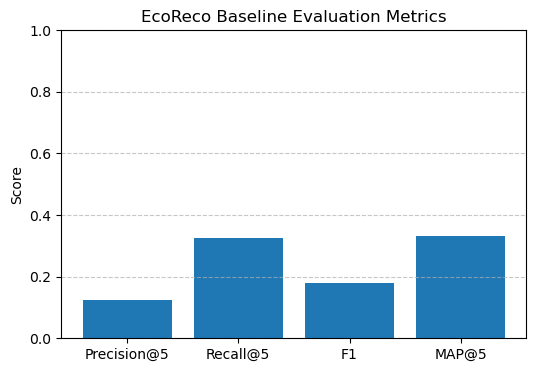

In [17]:
import matplotlib.pyplot as plt

metrics = ['Precision@5', 'Recall@5', 'F1', 'MAP@5']
values = [0.123, 0.326, 0.178, 0.333]

plt.figure(figsize=(6,4))
plt.bar(metrics, values)
plt.title('EcoReco Baseline Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
